In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
                'image/height': tf.FixedLenFeature([], tf.int64),
                'image/width': tf.FixedLenFeature([], tf.int64),
                'image/depth': tf.FixedLenFeature([], tf.int64),
                'label': tf.FixedLenFeature([], tf.int64),
                'image/raw': tf.VarLenFeature(tf.string)})

    # Shape elements must be int32 tensors!
    height = tf.cast(features['image/height'], tf.int32)
    width = tf.cast(features['image/width'], tf.int32)
    depth = tf.cast(features['image/depth'], tf.int32)
    
    # Decode the image from its raw representation:
    image = tf.decode_raw(features['image/raw'].values, tf.uint8)

    # Reshape it back to its original shape:
    im_shape = tf.pack([height, width, depth])
    image = tf.reshape(image, im_shape)
    #tf.random_crop(image, [height, width, depth])
    # Convert from [0, 255] -> [0, 1] floats.
    image = tf.cast(image, tf.float32) * (1. / 255)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int32)
    return image, label

In [4]:
image, label = read_and_decode("../data/cells_train.tfrecords")
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)
im_1, lab_1 = sess.run([image, label])

In [5]:
image, label = read_and_decode("../data/cells_train.tfrecords")
images_batch, labels_batch = tf.train.shuffle_batch(
    [image, label], batch_size=10,
    capacity=400,
    shapes=(im_1.shape, lab_1.shape),
    min_after_dequeue=200)

In [6]:
def weight_variable(shape, fan_in, fan_out):
    """ 
    Initialize weights with the Xavier initialization
    """
    low = -4*np.sqrt(6.0/(fan_in + fan_out)) 
    high = 4*np.sqrt(6.0/(fan_in + fan_out))
    return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [7]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [8]:
W_conv1 = weight_variable([5, 5, 3, 32], 256*256*3, 32)
b_conv1 = bias_variable([32])

First convolutional layer:

In [9]:
h_conv1 = tf.nn.relu(conv2d(images_batch, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

Second convolutional layer:

In [10]:
W_conv2 = weight_variable([5, 5, 32, 64], 128*128*32, 64)
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Fully connected layer:

In [11]:
h_pool2.get_shape()

TensorShape([Dimension(10), Dimension(64), Dimension(64), Dimension(64)])

In [12]:
W_fc1 = weight_variable([64 * 64 * 64, 1024], 64*64*64, 1024)
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 64 * 64 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Dropout:

In [13]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Readout:

In [14]:
W_fc2 = weight_variable([1024, 3], 1024, 3)
b_fc2 = bias_variable([3])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [15]:
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_conv, labels_batch)
loss_mean = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(1e-5).minimize(loss_mean)

In [16]:
y_pred = tf.cast(tf.argmax(y_conv, 1), tf.int32)

In [17]:
correct_prediction = tf.equal(y_pred, labels_batch)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
# # These variables are used for evaluation (helping to decide when to stop training):
# image_eval, label_eval = read_and_decode("../data/cells_eval.tfrecords")

# this_image = tf.placeholder("float", shape=[1, im_1.shape[0], im_1.shape[1], im_1.shape[2]])
# this_label = tf.placeholder("int32", shape=[])

# # Reproducing the entire network on eval data:
# h_conv1_eval = tf.nn.relu(conv2d(this_image, W_conv1) + b_conv1)
# h_pool1_eval = max_pool_2x2(h_conv1_eval)

# h_conv2_eval = tf.nn.relu(conv2d(h_pool1_eval, W_conv2) + b_conv2)
# h_pool2_eval = max_pool_2x2(h_conv2)

# h_pool2_flat_eval = tf.reshape(h_pool2, [-1, 64 * 64 * 64])
# h_fc1_eval = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# y_pred_eval = tf.matmul(h_fc1_eval, W_fc2) + b_fc2

# correct_prediction = tf.reduce_mean(
#     tf.cast(tf.equal(tf.cast(tf.argmax(y_pred_eval, 1), tf.int32), this_label), tf.int8))

In [19]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

[<Thread(Thread-4, started daemon 123145547661312)>,
 <Thread(Thread-5, started daemon 123145552916480)>,
 <Thread(Thread-6, started daemon 123145558171648)>]

In [20]:
mean_losses = []
for i in range(100):
    # Every 10 steps, evaluate accuracy:
    if i%10 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={keep_prob: 1.0})
        print("step %d, training accuracy %g" % (i, train_accuracy)) 

    _, loss_mean_val = sess.run([train_op, loss_mean], feed_dict={keep_prob: 0.5})
    mean_losses.append(loss_mean_val)
    print(loss_mean_val)

step 0, training accuracy 0.1
4.59583
97.8362
50.8063
45.7374
54.0524
27.2078
2.7953
33.5259
4.95413
15.3977
step 10, training accuracy 0.4
5.93069
3.9617
4.18758
5.09049
3.07566
2.73532
1.85238
1.75176
2.1985
1.66059
step 20, training accuracy 0.3
1.02634
1.31306
1.49257
0.999313
1.2427
1.04478
1.0548
0.988771
0.996578
0.932116
step 30, training accuracy 0.1
1.01739
1.19258
0.961293
1.04729
1.07643
0.727236
0.861332
0.839987
1.37751
1.84061
step 40, training accuracy 0.4
1.45401
1.32185
1.02408
0.88612
1.24057
1.35262
1.10012
1.32042
1.03975
1.2472
step 50, training accuracy 0.6
1.33491
1.23112
1.2214
1.28937
1.03781
1.10638
1.36075
1.07257
1.38713
1.0697
step 60, training accuracy 0.6
1.12484
1.21361
1.20904
1.20397
0.877946
1.28786
1.14204
1.29382
1.02098
1.19843
step 70, training accuracy 0.5
1.39144
1.13416
1.16539
1.063
1.07501
1.5122
1.28589
1.32029
1.1073
1.08224
step 80, training accuracy 0.3
1.06803
0.95657
1.11021
1.13795
1.35367
1.23982
0.73891
1.19062
1.11327
1.44782
step 

In [29]:
#sess.run(y_pred, feed_dict={keep_prob: 0.5})
sess.run(loss, feed_dict={keep_prob: 1.0})

array([ 0.40256444,  0.66997373,  1.46841836,  1.0090766 ,  1.04607761,
        1.53120852,  0.88761938,  1.02302587,  1.49911809,  1.01013064], dtype=float32)

In [21]:
# n_iterations = 0
# mean_losses = []
# mean_evals = []
# max_iterations = 5000

# while True:    
#     # We need to feed it the drop-out probability from a floating point variable
#     _, loss_mean_val = sess.run([train_op, loss_mean], feed_dict={keep_prob: 0.5})
#     # Store the loss so we can look at it:
#     mean_losses.append(loss_mean_val)
#     print(loss_mean_val)
#     # Every 10 learning iterations, we consider whether to stop:
#     if np.mod(n_iterations, 10) == 0:
#         p = []
#         # We're hard-coding the size of the entire eval data here and predicting them one by one:
#         for ii in range(169):
#             im, la = sess.run([image_eval, label_eval])
#             # It expects a 4D input, because that's what TF convs take as input:
#             im = im[np.newaxis, :]
#             p.append(sess.run(correct_prediction, feed_dict={this_image:im, this_label:la}))

#         mean_evals.append(np.mean(p))
#         print("After %s iterations, cross-validation accuracy is: %s" % (n_iterations, mean_evals[-1]))
#         # But we really only start thinking about stopping 
#         # after 2000 iterations:
#         if n_iterations > 2000:
#             # Here's how we decide whether to keep going, 
#             # based on the held-out data:            
#             # If you are still improving, relative to recent past keep training:
#             if mean_evals[-1] < (np.mean(mean_evals[-10:-1])):
#                 break

#     # If we're still around iterate:
#     n_iterations = n_iterations + 1  

#     # If you kept going for very long, break anyway:
#     if n_iterations > max_iterations:
#         break

NameError: name 'n_iterations' is not defined

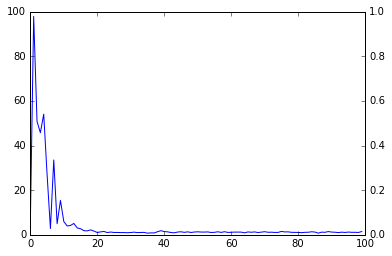

In [22]:
fig, ax = plt.subplots(1)
ax.plot(mean_losses)
ax2 = plt.twinx()
ax2.plot(np.arange(0, n_iterations+1, 10), mean_evals, 'ro')